> Para los productos que contienen en su descripción la palabra “stuff” (sin importar mayúsculas o minúsculas), calcular el peso total de su inventario agrupado por marca, mostrar sólo la marca y el peso total de las 5 más pesadas.

Para esta consulta, vamos a usar los datasets `products` e `inventory_logs`.

Vamos a empezar con lo más sencillo... filtrando y quedandonos con los productos que contienen "stuff" en su descripción.

In [1]:
import pandas as pd

products_df = pd.read_pickle('../../.data/clean/products.pkl')
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 1 to 1000000
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   product_name    939819 non-null   string        
 1   category_id     1000000 non-null  Int64         
 2   brand           939944 non-null   category      
 3   price           850000 non-null   Float64       
 4   cost            850000 non-null   Float64       
 5   stock_quantity  850000 non-null   Int64         
 6   weight_kg       850000 non-null   Float64       
 7   dimensions      940014 non-null   string        
 8   description     939716 non-null   string        
 9   is_active       1000000 non-null  boolean       
 10  created_at      910329 non-null   datetime64[ns]
dtypes: Float64(3), Int64(2), boolean(1), category(1), datetime64[ns](1), string(3)
memory usage: 84.9+ MB


In [70]:
KEY_WORD = "stuff"

REGEX_FILTER = rf"\b{KEY_WORD}\b"
stuff_products = products_df[
    products_df["description"].str.contains(REGEX_FILTER, case=False, na=False)
]

stuff_products = stuff_products[["brand", "weight_kg"]]
stuff_products

,brand,weight_kg
product_id,,
5,Ikea,31.47
23,La-Z-Boy,46.17
107,Dove,10.12
187,Warner Bros.,17.33
289,Yamaha,10.97
...,...,...
999793,Travelpro,48.84
999854,Trader Joe'S,27.03
999869,Ikea,46.19


Ahora vamos a intentar reconstruir el inventario actual de cada producto. Para eso, vamos a usar el dataset `inventory_logs`, que tiene un registro de todas las entradas y salidas de inventario por producto con su cantidad y fecha.

In [3]:
df_inventory = pd.read_pickle('../../.data/clean/inventory_logs.pkl')

df_inventory = df_inventory[['product_id', 'movement_type', 'quantity_change', 'timestamp']]
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400000 entries, 1 to 400000
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       400000 non-null  Int64         
 1   movement_type    364060 non-null  category      
 2   quantity_change  340000 non-null  Int64         
 3   timestamp        363851 non-null  datetime64[ns]
dtypes: Int64(2), category(1), datetime64[ns](1)
memory usage: 13.4+ MB


Como no podemos operar si no sabemos datos del producto, tipo de movimiento o cantidad, vamos a descartar las filas que tengan datos nulos en esas columnas y de a poco ir simplificando el dataframe. En el caso de los productos, ya tenemos todos como NO nulos así que no hace falta comprobar.

In [4]:
df_inventory = df_inventory.dropna(
    subset=["movement_type", "quantity_change"]
)
df_inventory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309268 entries, 1 to 400000
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       309268 non-null  Int64         
 1   movement_type    309268 non-null  category      
 2   quantity_change  309268 non-null  Int64         
 3   timestamp        281384 non-null  datetime64[ns]
dtypes: Int64(2), category(1), datetime64[ns](1)
memory usage: 10.3+ MB


Luego sería ideal simplificar los movimientos a un solo valor real positivo o negativo, para poder sumar todo al final y obtener el inventario actual. Para eso, vamos a crear una nueva columna `quantity_signed` que va a tener el valor de `quantity_change` pero con el signo cambiado si el `movement_type` es "OUT". El otro caso es si el `movement_type` es "ADJUSTMENT", en ese caso vamos a asumir que el valor de `quantity_change` ya tiene el signo correcto y lo dejamos igual.

In [5]:
df_inventory["quantity_signed"] = df_inventory.apply(
    lambda row: -row["quantity_change"]
    if row["movement_type"] == "OUT"
    else row["quantity_change"],
    axis=1,
)

df_inventory = df_inventory[["product_id", "quantity_signed", "timestamp"]]
df_inventory["product_id"] = df_inventory["product_id"].astype(str)

df_inventory.head()

,product_id,quantity_signed,timestamp
log_id,,,
1,996381,228,2023-08-21 04:33:50.446753
4,997550,260,2024-09-03 20:47:37.637720
5,978028,263,2024-10-19 08:55:45.508647
6,990089,6,2025-06-02 12:53:02.444493
7,911658,87,2024-04-03 01:01:52.216227


Ahora que ya tenemos todo reducido a lo que necesitamos, podemos hacer un inner join entre el dataframe de productos y el de inventario, usando `product_id` como clave. Luego a esto lo podemos agrupar por producto y sumar los movimientos para obtener el inventario actual de cada producto.

In [6]:
merged_products_inventory = pd.merge(
    stuff_products, df_inventory, left_index=True, right_on="product_id", how="inner"
)

merged_products_inventory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4750 entries, 20301 to 274325
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   brand            4453 non-null   category      
 1   weight_kg        4038 non-null   Float64       
 2   product_id       4750 non-null   object        
 3   quantity_signed  4750 non-null   int64         
 4   timestamp        4292 non-null   datetime64[ns]
dtypes: Float64(1), category(1), datetime64[ns](1), int64(1), object(1)
memory usage: 200.7+ KB


In [12]:
inventory_by_product = merged_products_inventory.groupby(["product_id"]).agg(
    {
        "brand": "first",  # en este caso como todas las filas de un producto tienen la misma marca, podemos usar "first"
        "weight_kg": "first",  # IDEM
        "quantity_signed": "sum",
    }
)

inventory_by_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 900142 to 999984
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   brand            1368 non-null   category
 1   weight_kg        1236 non-null   Float64 
 2   quantity_signed  1458 non-null   int64   
dtypes: Float64(1), category(1), int64(1)
memory usage: 39.7+ KB


In [13]:
inventory_by_product.describe()

,weight_kg,quantity_signed
count,1236.0,1458.000000
mean,24.917298,551.434842
std,14.469504,422.360405
min,0.1,-202.000000
25%,12.2375,227.000000
50%,25.605,486.500000
75%,37.34,815.750000
max,49.96,2558.000000


Ya con toda esta información podemos calcular el peso total del inventario por marca. Para esto primero vamos a crear una nueva columna que calcule el peso total del inventario de cada producto, multiplicando el peso por unidad por la cantidad en inventario. Luego podemos agrupar por marca y sumar los pesos totales para obtener el peso total del inventario por marca.

Como aclaración, es normal que tengamos productos con inventario negativo, ya que en el dataset del inventario descartamos algunos movimientos con información incompleta que pueden haber afectado el inventario final de algunos productos. Obviamente esto podría ser también un problema en la vida real donde se hayan pasado por alto algunos IN/OUT/ADJUSTMENT, pero para este ejercicio vamos a trabajar con lo que tenemos.

Como decisión de diseño, vamos a descartar los productos que tienen peso nulo o que la cantidad según el inventario es menor o igual a 0, ya que probablemente distorsionen el resultado final.

In [68]:
inventory_by_product = inventory_by_product.dropna(subset=["weight_kg"])
inventory_by_product = inventory_by_product[inventory_by_product["quantity_signed"] > 0]

inventory_by_product["total_weight_kg"] = (
    inventory_by_product["weight_kg"] * inventory_by_product["quantity_signed"]
)

weight_by_product = inventory_by_product[["brand", "total_weight_kg"]]
weight_by_product

,brand,total_weight_kg
product_id,,
900142,Trader Joe'S,12602.86
900157,Dr. Martens,11651.04
900229,Winsor & Newton,21534.75
900247,Ticketmaster,3887.76
900294,Lowe'S,4492.28
...,...,...
999793,Travelpro,1123.32
999854,Trader Joe'S,6027.69
999869,Ikea,35612.49


In [66]:
weight_by_brand = weight_by_product.groupby("brand", observed=True).agg(
    total_inventory_weight_kg=("total_weight_kg", "sum"),
    product_count=("total_weight_kg", "count"),
)

weight_by_brand

,total_inventory_weight_kg,product_count
count,153.0,153.0
mean,105288.910327,7.111111
std,70533.52866,3.931244
min,525.4,1.0
25%,55786.08,5.0
50%,91403.01,7.0
75%,129844.8,8.0
max,491074.67,32.0


Ahora tenemos el peso total del inventario por marca, nos resta encontrar los 5 más pesadas. Antes vamos a ver un poco las estadísticas descriptivas para entender mejor los datos.

In [57]:
weight_by_brand.describe()

,total_inventory_weight_kg,product_count
count,155.0,155.0
mean,103930.343742,7.019355
std,71080.811081,3.987759
min,0.0,0.0
25%,53987.15,5.0
50%,91344.99,7.0
75%,129543.09,8.0
max,491074.67,32.0


En este caso la información esta bastante dispersa, no se encuentra todo concentrado al rededor de un valor puntual. La media nos indica que 100k kg por marca con un desvió de 70k kg. Vamos a graficar un violín plot para ver mejor la distribución de las marcas.

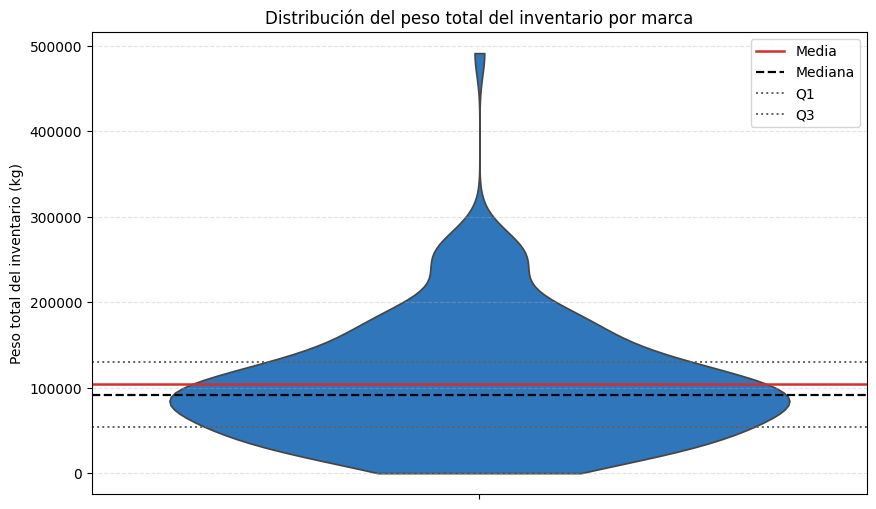

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

serie = weight_by_brand["total_inventory_weight_kg"]
color = "#1976D2"

plt.figure(figsize=(10, 6))
ax = sns.violinplot(y=serie, color=color, inner=None, cut=0)

mean_val = serie.mean()
median_val = serie.median()
q1 = serie.quantile(0.25)
q3 = serie.quantile(0.75)

ax.axhline(mean_val, color="#D32F2F", linestyle="-", linewidth=1.8, label="Media")
ax.axhline(median_val, color="#000000", linestyle="--", linewidth=1.6, label="Mediana")
ax.axhline(q1, color="#616161", linestyle=":", linewidth=1.4, label="Q1")
ax.axhline(q3, color="#616161", linestyle=":", linewidth=1.4, label="Q3")

ax.yaxis.grid(True, linestyle="--", alpha=0.35)
ax.set_title("Distribución del peso total del inventario por marca")
ax.set_xlabel("")
ax.set_ylabel("Peso total del inventario (kg)")
ax.legend(loc="upper right")
plt.show()

En esta visualización podemos ver que hay muchas marcas que se comportan de forma "normal" respecto a los datos pero tenemos algunos outliers que aparecen entre los 400k y 500k que sean los que probablemente terminen en el top 5 marcas más pesadas.

Vamos a ver de paso con un gráfico de caja cuantos outliers tenemos aproximadamente ya que el violín plot suaviza mucho la información y puede que se distorsione un poco la realidad.

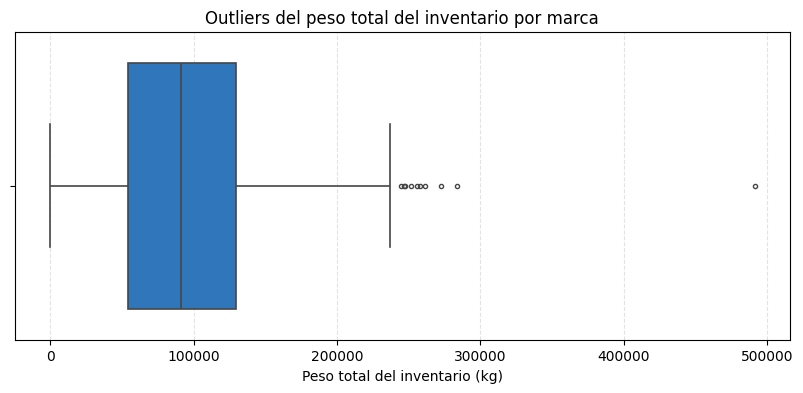

In [47]:
serie = weight_by_brand["total_inventory_weight_kg"]

plt.figure(figsize=(10, 4))
ax = sns.boxplot(x=serie, color="#1976D2", fliersize=3, linewidth=1.2, whis=1.5)
ax.xaxis.grid(True, linestyle="--", alpha=0.35)
ax.set_title("Outliers del peso total del inventario por marca")
ax.set_xlabel("Peso total del inventario (kg)")
ax.set_ylabel("")
plt.show()

Particularmente vemos un outlier muy marcado que está cerca de los 500k kg y algunos más cerca de los 250k kg que aunque más raros, se encuentran en un rango de valores normales y es normal que aparezcan valores por fuera de los bigotes sobre todo si el devío estandar es grande y la cantidad de marcas es relativamente alta (150 aproximadamente).

Ya dadas las hipótesis, pasemos a ver las 5 marcas más pesadas.

In [49]:
TOP_N_BRANDS = 5

sorted_brands_by_total_weight = weight_by_brand.sort_values(by="total_inventory_weight_kg", ascending=False)
top_n_brands = sorted_brands_by_total_weight.head(TOP_N_BRANDS)

top_n_brands

,total_inventory_weight_kg,product_count
brand,,
Undefined,491074.67,32
Gardena,283674.25,14
Vetriscience,272768.03,12
Adidas,261657.25,14
Bosch,257753.56,13


Ahí sale a relucir el outlier que vimos en el gráfico de caja, la marca que generaba disturbios en la distribución es aquella de los valores nulos ya que nunca descartamos estos valores y es la categoría donde caen todos los productos sin marca.

Para tener un mejor análisis, podemos hacer un análisis equivalente pero sin considerar los productos sin marca, ya que es un caso especial y no nos habla de cuales marcas son las que más inventario acumulan.

In [76]:
non_null_brands = weight_by_brand.dropna()
non_null_brands = non_null_brands[non_null_brands.index != "Undefined"]

non_null_brands.describe()

,total_inventory_weight_kg,product_count
count,152.0,152.0
mean,102750.846118,6.947368
std,63370.400455,3.380484
min,525.4,1.0
25%,55401.7775,5.0
50%,91374.0,7.0
75%,129392.235,8.0
max,283674.25,23.0


Como vemos, ahora el outlier desaparece y la distribución de los datos es mucho más normal, con una media de 100k kg y un desvió de 63k kg. Podemos ver la difrerencia de la distribución con un nuevo violin plot más un gráfico de caja.

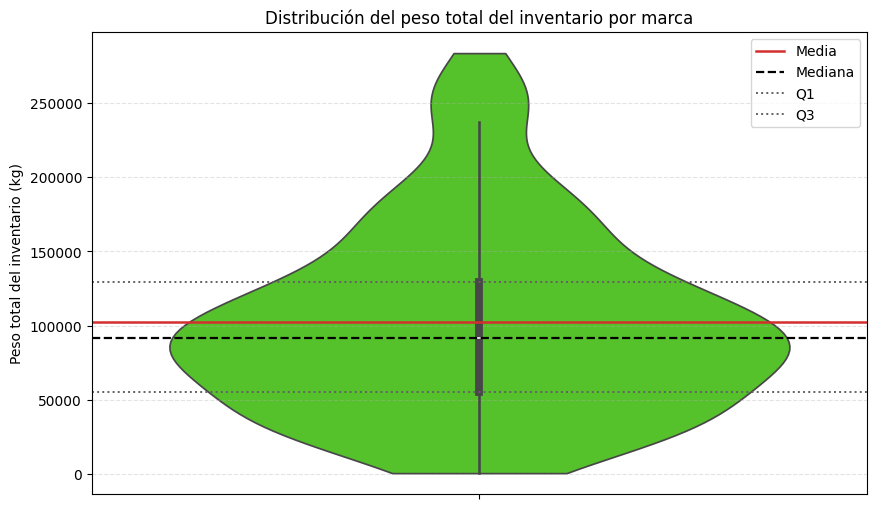

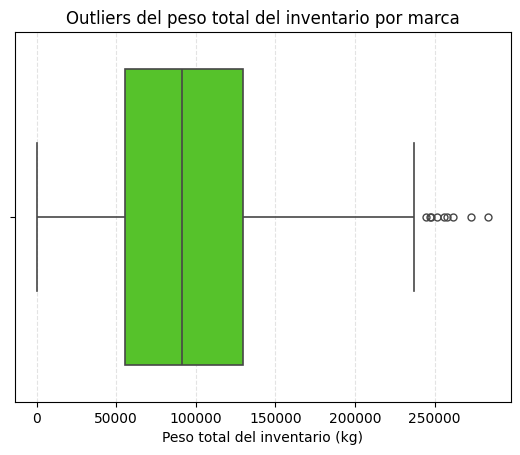

In [87]:
serie = non_null_brands["total_inventory_weight_kg"]
color = "#4BDB12"

plt.figure(figsize=(10, 6))
ax = sns.violinplot(y=serie, color=color, cut=0)

mean_val = serie.mean()
median_val = serie.median()
q1 = serie.quantile(0.25)
q3 = serie.quantile(0.75)

ax.axhline(mean_val, color="#D32F2F", linestyle="-", linewidth=1.8, label="Media")
ax.axhline(median_val, color="#000000", linestyle="--", linewidth=1.6, label="Mediana")
ax.axhline(q1, color="#616161", linestyle=":", linewidth=1.4, label="Q1")
ax.axhline(q3, color="#616161", linestyle=":", linewidth=1.4, label="Q3")

ax.yaxis.grid(True, linestyle="--", alpha=0.35)
ax.set_title("Distribución del peso total del inventario por marca")
ax.set_xlabel("")
ax.set_ylabel("Peso total del inventario (kg)")
ax.legend(loc="upper right")
plt.show()

ax = sns.boxplot(x=serie, color=color, fliersize=3, linewidth=1.2, whis=1.5)
ax.xaxis.grid(True, linestyle="--", alpha=0.35)
ax.set_title("Outliers del peso total del inventario por marca")
ax.set_xlabel("Peso total del inventario (kg)")
ax.set_ylabel("")
plt.show()

Claramente ahora la distribución es mucho más normal y estos outliers son más realistas y resultarán aquellos en el TOP 5.

In [88]:
sorted_non_null_brands = non_null_brands.sort_values(by="total_inventory_weight_kg", ascending=False)
top_n_non_null_brands = sorted_non_null_brands.head(TOP_N_BRANDS)

top_n_non_null_brands

,total_inventory_weight_kg,product_count
brand,,
Gardena,283674.25,14
Vetriscience,272768.03,12
Adidas,261657.25,14
Bosch,257753.56,13
Stubhub,255881.28,12


Las marcas son las misma que antes sumando a "Stubhub".

Otro análisis que puede resultar interesante es la distribución de la variedad de productos con "stuff" por marca con respecto al peso total del inventario de la marca. Los datos ya los tenemos, solo hace falta ver si tenemos correlación entre estas 2 variables. Para ello calcularemos la matriz de correlación y graficaremos un scatter plot para ver si esta relación es lineal o no.

In [90]:
correlation_matrix = non_null_brands.corr()
correlation_matrix

,total_inventory_weight_kg,product_count
total_inventory_weight_kg,1.000000,0.774223
product_count,0.774223,1.000000


Parece que hay una alta correlación positiva entre la cantidad de productos con "stuff" y el peso total del inventario por marca, con un coeficiente de 0.77. Veamos si es una correlación lineal o se ve más marcada por algun rango de valores.

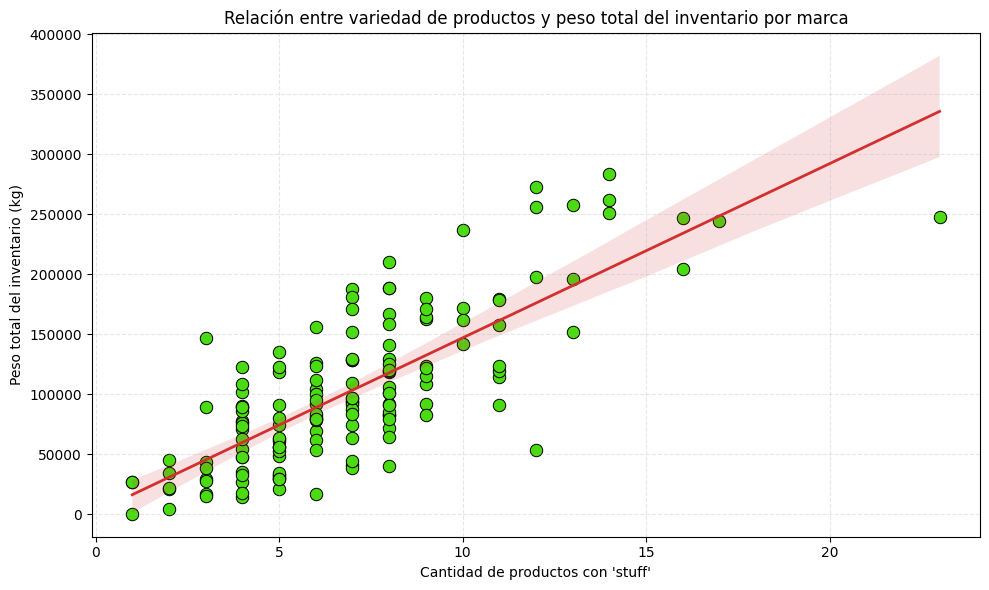

In [95]:
color = "#4BDB12"
df = non_null_brands

plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=df,
    x="product_count",
    y="total_inventory_weight_kg",
    color=color,
    s=80,
    edgecolor="black",
)
sns.regplot(
    data=df,
    x="product_count",
    y="total_inventory_weight_kg",
    scatter=False,
    color="#D32F2F",
    line_kws={"lw": 2},
    ax=ax,
)
plt.title("Relación entre variedad de productos y peso total del inventario por marca")
plt.xlabel("Cantidad de productos con 'stuff'")
plt.ylabel("Peso total del inventario (kg)")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

Vemos como aparece está tendencia creciente efectivamente, pero también aparecen algunos pilares que surgen por la poca granularidad que tiene la distribución de la cantidad de productos por marca. Una forma más fehaciente de ver esto entonces es introduciendo la noción de buckets que agrupen las marcas por rangos de cantidad de productos y graficando el promedio del peso total del inventario por cada bucket. Esto se puede hacer con un gráfico de tipo bar plot.

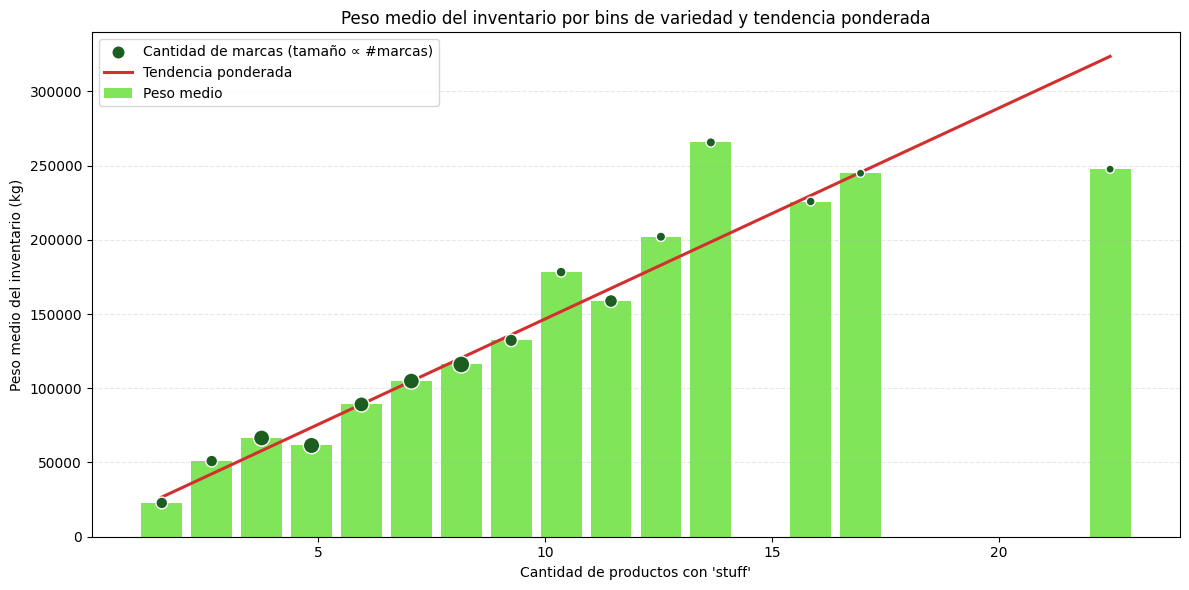

In [238]:
import numpy as np

color = "#4BDB12"
df = non_null_brands

pc = df["product_count"]
weights = df["total_inventory_weight_kg"]

# Definimos bins automáticamente (maneja bien distintos tamaños):
bin_edges = np.histogram_bin_edges(pc, bins="auto")

# Asignamos cada marca a un bin según su product_count
binned = pd.cut(pc, bins=bin_edges, include_lowest=True)

# Agregamos: promedio de peso por bin y cantidad de marcas por bin
agg = (
    df.groupby(binned, observed=True)
    .agg(
        mean_weight=("total_inventory_weight_kg", "mean"),
        count=("total_inventory_weight_kg", "size"),
    )
    .dropna(subset=["mean_weight"])
)

centers = agg.index.map(lambda index: (index.left + index.right) / 2)
agg = agg.assign(center=centers.values)


x = agg["center"].to_numpy()
y = agg["mean_weight"].to_numpy()
w = np.sqrt(agg["count"].to_numpy().astype(float))

plt.figure(figsize=(12, 6))

plt.bar(
    agg["center"],
    agg["mean_weight"],
    width=0.9,
    color=color,
    alpha=0.7,
    label="Peso medio",
)

sizes = 30 + 120 * (agg["count"] / agg["count"].max())
plt.scatter(
    agg["center"],
    agg["mean_weight"],
    s=sizes,
    color="#1B5E20",
    edgecolor="white",
    zorder=3,
    label="Cantidad de marcas (tamaño ∝ #marcas)",
)

m, b = np.polyfit(x, y, deg=1, w=w)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = m * x_line + b
plt.plot(
    x_line, y_line, color="#D32F2F", linewidth=2.2, label="Tendencia ponderada"
)

plt.title("Peso medio del inventario por bins de variedad y tendencia ponderada")
plt.xlabel("Cantidad de productos con 'stuff'")
plt.ylabel("Peso medio del inventario (kg)")
plt.grid(True, linestyle="--", alpha=0.3, axis="y")
plt.legend()
plt.tight_layout()
plt.show()

Como vemos es bastante lineal y estable el crecimiento, por lo que podemos concluir que efectivamente la dispersión de peso y cantidad de stock por producto es muy similar, al menos para estos productos correspondientes al top 5 marcas.

Otro analisis posible es de la evolución de los pesos totales del inventario por marca a lo largo del tiempo. Para ello vamos a tomar solo las 5 marcas más pesadas y vamos a ver como evolucionó su peso total del inventario a lo largo del tiempo.

El primer paso sería ver que rango temporal tenemos en el dataset de inventario.

In [97]:
merged_products_inventory.describe()

,weight_kg,quantity_signed,timestamp
count,4038.0,4750.000000,4292
mean,25.119079,169.261474,2024-07-15 03:39:49.213987328
min,0.1,-100.000000,2023-07-17 23:09:04.239020
25%,12.37,28.000000,2024-01-18 08:38:49.346192384
50%,26.215,122.000000,2024-07-11 06:04:43.055015936
75%,37.36,321.000000,2025-01-12 16:43:15.308692992
max,49.96,500.000000,2025-07-17 08:23:49.700728
std,14.447712,171.042717,NaN


Vemos que la fecha más vieja es del 2023-07-17 y la más reciente del 2025-07-17. Por lo que para 2 años tendría sentido hacer una análisis por cuatrimestres (quarters).

Para ellos vamos a primero definir los cuatrimestres como 2023-Q3, 2023-Q4 y así hasta 2025-Q2. Luego vamos a filtrar el dataset de inventario para quedarnos solo con los productos de las 5 marcas más pesadas, luego vamos a agrupar por producto y cuatrimestre y sumar la cantidad en inventario para cada producto en cada cuatrimestrel. Luego calcularemos el peso total del inventario por producto y cuatrimestre y finalmente agruparemos por marca y cuatrimestre para sumar el peso total del inventario por marca y cuatrimestre.

In [134]:
products_inventory_with_quarters_in_top_brands = merged_products_inventory[
    merged_products_inventory["brand"].isin(top_n_non_null_brands.index)
].copy()

products_inventory_with_quarters_in_top_brands["quarter"] = products_inventory_with_quarters_in_top_brands["timestamp"].dt.to_period("Q").astype("category")

products_inventory_with_quarters_in_top_brands = products_inventory_with_quarters_in_top_brands[
    ["brand", "weight_kg", "product_id", "quantity_signed", "quarter"]
]

products_inventory_with_quarters_in_top_brands

,brand,weight_kg,product_id,quantity_signed,quarter
log_id,,,,,
124481,Stubhub,44.5,900434,410,2024Q1
295199,Stubhub,44.5,900434,469,2025Q2
320334,Stubhub,44.5,900434,293,2024Q1
334747,Stubhub,44.5,900434,155,2024Q2
43556,Adidas,13.4,902214,-84,2025Q1
...,...,...,...,...,...
307622,Vetriscience,38.09,994781,294,2023Q4
328384,Vetriscience,38.09,994781,260,2024Q1
162470,Adidas,38.46,998303,274,2024Q3


In [154]:
variation_of_inventory_by_product_and_quarter = products_inventory_with_quarters_in_top_brands.groupby(
    ["brand", "product_id", "quarter"], observed=True
).agg(
    {
        "brand": "first",
        "weight_kg": "first",
        "quantity_signed": "sum",
    },
)

variation_of_inventory_by_product_and_quarter["weight_kg_variation"] = (
    variation_of_inventory_by_product_and_quarter["weight_kg"]
)

variation_of_inventory_by_product_and_quarter = variation_of_inventory_by_product_and_quarter[
    ["weight_kg_variation"]
]

variation_of_inventory_by_product_and_quarter

weight_kg_variation
brand        product_id quarter                     
Adidas       902214     2024Q4                  13.4
                        2025Q1                  13.4
                        2025Q2                  13.4
             903231     2023Q4                 34.36
                        2024Q2                 34.36
...                                              ...
Vetriscience 983572     2023Q4                  14.9
             987925     2024Q4                 44.85
             994781     2023Q4                 38.09
                        2024Q1                 38.09
                        2024Q4                 38.09

[216 rows x 1 columns]

Acumulamos las variaciones netas por marca por cuatrimestre

In [221]:
grouped_variation = variation_of_inventory_by_product_and_quarter.groupby(
    ["brand", "quarter"], observed=True
).agg(
    total_weight_variation_kg=("weight_kg_variation", "sum"),
)

grouped_variation.head(10)

total_weight_variation_kg
brand  quarter                           
Adidas 2023Q3                       86.66
       2023Q4                      118.39
       2024Q1                      130.36
       2024Q2                      131.35
       2024Q3                       92.37
       2024Q4                      102.76
       2025Q1                      138.58
       2025Q2                      180.33
       2025Q3                       77.82
Bosch  2023Q3                       135.1

Vamos ahora a acumular las variaciones netas por marca y cuatrimestre para ver la evolución del peso total del inventario de las 5 marcas más pesadas a lo largo del tiempo.

In [225]:
all_brands = top_n_non_null_brands.index.unique()
all_quarters = grouped_variation.index.get_level_values('quarter').unique()

acumulated_weight_by_brand = {}

for brand in all_brands:
    brand_data = grouped_variation.loc[brand].sort_index()

    brand_data = brand_data.reindex(all_quarters, fill_value=0)
    brand_data["acumulated_weight_kg"] = brand_data["total_weight_variation_kg"].cumsum()
    acumulated_weight_by_brand[brand] = brand_data

acumulated_weight_df = pd.concat(
    acumulated_weight_by_brand.values(), keys=acumulated_weight_by_brand.keys()
)
acumulated_weight_df.index.names = ["brand", "quarter"]
acumulated_weight_df = acumulated_weight_df[["acumulated_weight_kg"]]
acumulated_weight_df["acumulated_weight_kg"] = acumulated_weight_df["acumulated_weight_kg"].astype(float).round(2).fillna(0.0)
acumulated_weight_df.head(20)

acumulated_weight_kg
brand        quarter                      
Gardena      2023Q3                 143.22
             2023Q4                 374.77
             2024Q1                 562.66
             2024Q2                 727.28
             2024Q3                 880.95
             2024Q4                 977.09
             2025Q1                1127.66
             2025Q2                1267.75
             2025Q3                1296.78
Vetriscience 2023Q3                  21.48
             2023Q4                 233.48
             2024Q1                 394.89
             2024Q2                 442.86
             2024Q3                 499.45
             2024Q4                 708.61
             2025Q1                 879.95
             2025Q2                1037.61
             2025Q3                1087.23
Adidas       2023Q3                  86.66
             2023Q4                 205.05

Ahora con toda la información podemos hacer un buen gráfico de líneas para ver la evolución del peso total del inventario de las 5 marcas más pesadas a lo largo del tiempo.

In [267]:
df_long = acumulated_weight_df.reset_index()
df_long["q"] = df_long["quarter"].astype(str)

brands = df_long["brand"].unique().tolist()

colors = sns.color_palette("tab10", n_colors=len(brands))
palette = {b: c for b, c in zip(brands, colors)}

sns.set_theme(style="whitegrid")

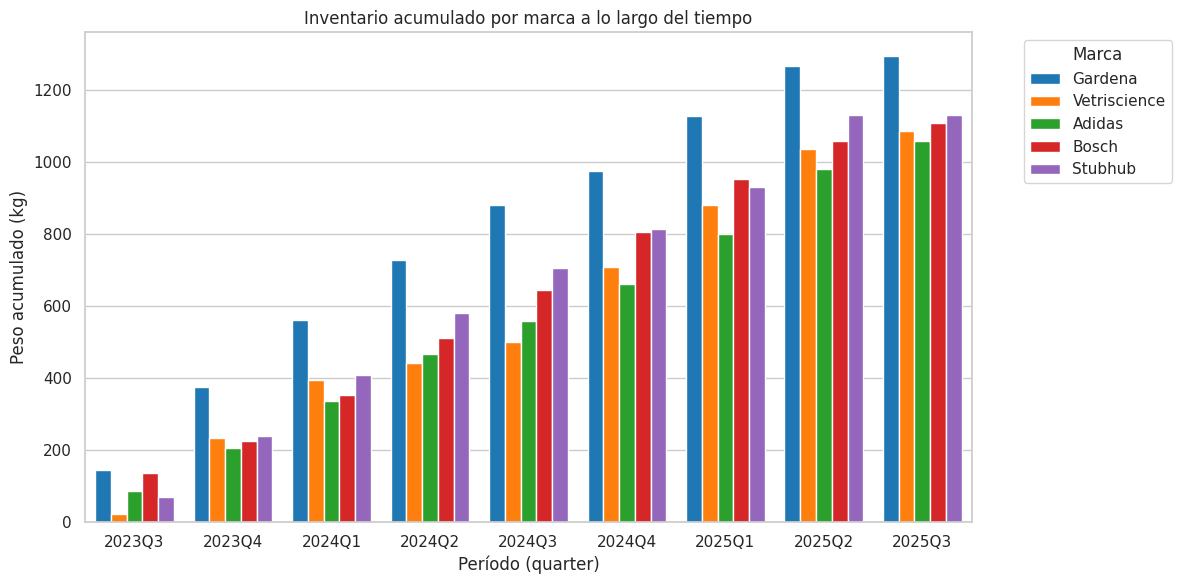

In [268]:
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=df_long,
    x="quarter",
    y="acumulated_weight_kg",
    hue="brand",
    hue_order=brands,
    palette=palette,
    errorbar=None,
    edgecolor=None,
    saturation=1.0
)
ax.set_title("Inventario acumulado por marca a lo largo del tiempo")
ax.set_xlabel("Período (quarter)")
ax.set_ylabel("Peso acumulado (kg)")
ax.legend(title="Marca", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Como vemos, el crecimiento fue bastante sostenido a lo largo del tiempo, cada vez acumulan más stock. por otro lado, a simple vista no se ve que las proporciones de cada empresa crezcan demasiado respecto a las otras... pero podemos validar mejor eso haciendo un grafico apilado por período y corroborando el porcentaje de peso de cada empresa respecto a las demás.

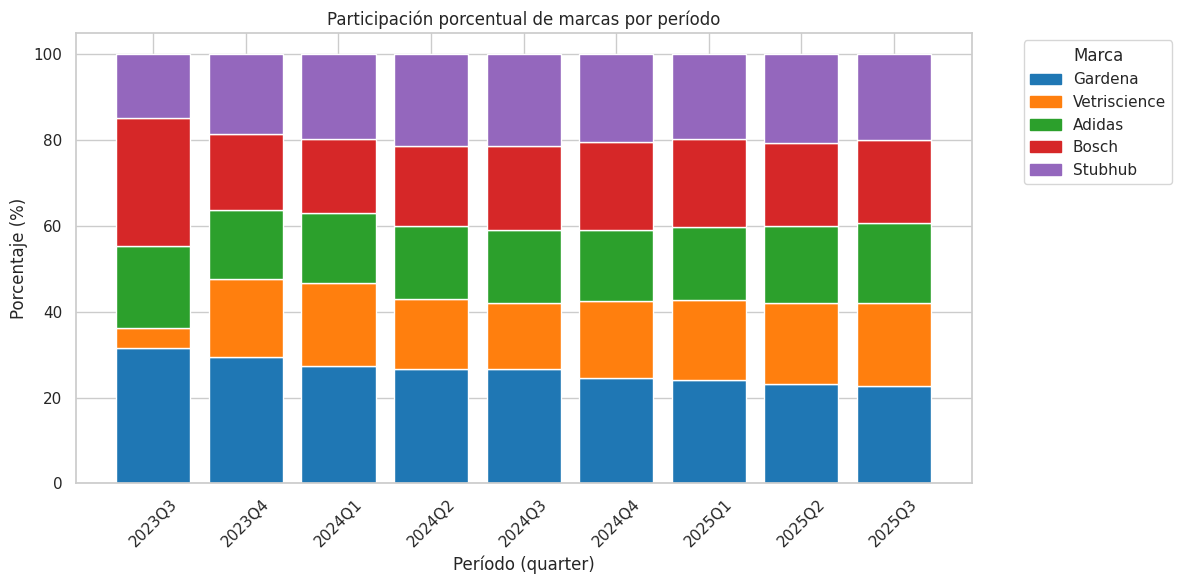

In [269]:
import matplotlib.patches as mpatches

dfp = (df_long
       .assign(total_q=df_long.groupby("q")["acumulated_weight_kg"].transform("sum"))
       .assign(percent=lambda d: d["acumulated_weight_kg"]/d["total_q"]*100))

plt.figure(figsize=(12,6))
bottoms = {q: 0.0 for q in dfp["q"].unique()}

for b in brands:
    sub = dfp[dfp["brand"] == b]
    q_vals = sub["q"].tolist()
    heights = sub["percent"].tolist()
    plt.bar(
        q_vals, heights,
        bottom=[bottoms[q] for q in q_vals],
        color=palette[b],
        edgecolor=None
    )
    for q, h in zip(q_vals, heights):
        bottoms[q] += h

handles = [mpatches.Patch(color=palette[b], label=b) for b in brands]
plt.legend(handles=handles, title="Marca", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.title("Participación porcentual de marcas por período")
plt.xlabel("Período (quarter)")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como vemos no hubo un cambio en el dominio de una marca sobre otra a lo largo del tiempo, exceptiando en el primer quarter, pero tiene sentido que esto sea así por que los datos arrancan un 17 de julio y no exactamente por el quarter, por lo que ese primero habría que tomarlo con pinzas.